In [1]:
import pandas as pd
import numpy as np
import os
import json
import pickle
from collections import defaultdict
from datetime import datetime
import openai
import requests
from tenacity import retry, wait_random_exponential, stop_after_attempt
from termcolor import colored

In [2]:
user_profile_path = './data/user_profile.json'
with open(user_profile_path, 'r') as f:
    user_profile = json.load(f)
print(len(user_profile))

1273


In [4]:
item_information_path = './processed_data/processed_item_information.json'
with open(item_information_path, 'r') as f:
    item_information_dict = json.load(f)
print(len(item_information_dict))

6089


In [7]:
item_information_dict['2']

{'title': 'Allegra K Ladies Boat Neck Short Dolman Sleeve Cape Style Fashion Top Large / US 14 Khaki',
 'description': '\n\nThe product is a cute, warm, and versatile sweater that is comfortable and flattering, but may have issues with sizing and quality of material.'}

In [8]:
ratings_path = './processed_data/ratings.csv'
ratings_df = pd.read_csv(ratings_path)
ratings_df.head()

,item,user,rating,timestamp
0,0,0,4.0,1452816000
1,1,0,4.0,1453766400
2,2,0,3.0,1453766400
3,3,0,4.0,1453766400
4,4,0,4.0,1453766400


In [9]:
def get_item_description(item_information):
    item_details = ""
    if 'title' in item_information:
        item_details += item_information['title']
    if 'brand' in item_information:
        item_details += f" Brand: {item_information['brand']}"
    if 'price' in item_information:
        item_details += f" Price: {item_information['price']}"
    if 'description' in item_information:
        item_details += f" Description: {item_information['description']}"
    return item_details

In [15]:
user_profile_summary_prompt_dict = dict()
for user, profile in user_profile.items():
    if len(profile) == 0:
        continue
    # print(f"User: {user} Profile: {profile}")
    user_rating_dict = ratings_df[ratings_df['user'] == int(user)]
    # print(user_rating_dict)
    prompt = "You are an expert fashion product reviewer and recommender. You are provided with a user's list of recent products and their descriptions that the user purchases and whether the user liked it or disliked it. Please go through the list in order -\n"
    for item in profile[:15]:
        user_item_rating = user_rating_dict[user_rating_dict['item'] == item]['rating'].values[0]
        if user_item_rating > 3:
            ### Liked
            prompt += f"Liked {get_item_description(item_information_dict[str(item)])}\n"
        else:
            prompt += f"Disliked {get_item_description(item_information_dict[str(item)])}\n"
    prompt += """You are an expert fashion product reviewer and recommender. Analyze the provided list of products purchased by the user in order and summarize the user behavior by identifying the characteristics he liked and disliked about the products in at most 100 words.
    Do not include information not present in the item descriptions."""
    user_profile_summary_prompt_dict[user] = prompt
    # break
print(len(user_profile_summary_prompt_dict))

896


In [18]:
total_len = 0
all_prompt_lens = []
for user, prompt in user_profile_summary_prompt_dict.items():
    all_prompt_lens.append(len(prompt.strip().split(' ')))
    total_len += len(prompt.strip().split(' '))
print(total_len/len(user_profile_summary_prompt_dict))

270.74888392857144


(array([  3.,   3.,  13.,  39.,  72., 337.,  29.,  22.,  11.,  11.,  26.,
         51.,  24.,   8.,  11.,  12.,   5.,  17.,   8.,  21.,  14.,  14.,
          4.,   3.,   6.,   3.,   4.,   3.,   8.,   7.,   6.,   4.,   5.,
          4.,   1.,   1.,   4.,   0.,   2.,   3.,   6.,   2.,   4.,   0.,
          1.,   3.,   2.,   1.,   2.,   4.,   2.,   2.,   1.,   0.,   1.,
          1.,   3.,   2.,   0.,   0.,   2.,   1.,   1.,   1.,   1.,   0.,
          0.,   0.,   0.,   0.,   2.,   1.,   1.,   0.,   0.,   2.,   0.,
          1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   1.,
          0.,   2.,   1.,   0.,   2.,   1.,   1.,   2.,   0.,   2.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

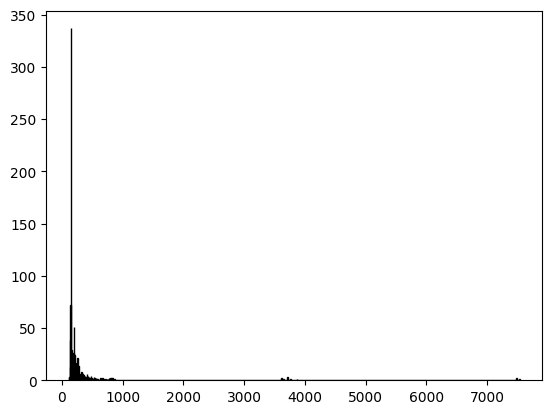

In [19]:
import matplotlib.pyplot as plt

plt.hist(all_prompt_lens, bins=1000, edgecolor='black')

In [30]:
very_long_prompts_users = list()
for user, prompt in user_profile_summary_prompt_dict.items():
    if len(prompt.strip().split(' ')) > 500:
        very_long_prompts_users.append(user)
print(len(very_long_prompts_users))

47


In [31]:
print(very_long_prompts_users)

['173', '238', '239', '310', '316', '330', '382', '385', '404', '471', '535', '542', '562', '613', '636', '638', '653', '661', '680', '683', '718', '757', '760', '766', '787', '809', '811', '815', '824', '845', '868', '890', '934', '936', '947', '958', '963', '966', '1043', '1058', '1062', '1129', '1140', '1193', '1204', '1232', '1245']


In [32]:
for user in very_long_prompts_users:
    user_profile_summary_prompt_dict.pop(user, None)

In [33]:
print(len(user_profile_summary_prompt_dict))

849


In [36]:
user_profile_summary_prompt_path = './data/user_profile_summary_prompt_dict.json'
with open(user_profile_summary_prompt_path, 'w') as f:
    json.dump(user_profile_summary_prompt_dict, f)
    f.close()